<a href="https://colab.research.google.com/github/retuyu88/digitalentkominfo/blob/master/Copy_of_%5B28_6%5D_Style_Transfer_using_TF2_ADF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = "https://i.imgur.com/UjutVJd.jpg" align = "center">

# Neural Style Transfer Introduction
Dalam tutorial ini, kita akan belajar bagaimana menggunakan pembelajaran yang mendalam untuk menyusun gambar dalam gaya gambar lain (pernah berharap Anda bisa melukis seperti Picasso atau Van Gogh?). Ini dikenal sebagai **Neural Style Transfer**


Teknik ini diperkenalkan oleh [Leon A. Gatys ', Algoritme Syaraf Gaya Artistik] (https://arxiv.org/abs/1508.06576)


*Neural Style Transfer* adalah teknik optimasi yang digunakan untuk memproses tiga gambar: ***Content Image***, ***Style Reference Image*** yaitu sumber gambar yang ingin kita tiru stylenya, dan ***Input Image*** yang ingin kita ubah stylenya. Ketiga gambar tersebut kemudian akan digabungkan sehingga *Input Image* tertransformasi dan tergambarkan ulang ke dalam *Content Image* namun "Tergambarkan" dengan style dari *Style Reference Image*

Sebagai contoh, mari kita ambil gambar dari kura-kura ini dan Katsushika Hokusai's * The Great Wave off Kanagawa *:

Sea Turtle | The Great Wave off Kanagawa
---|---
<img src = "https://github.com/tensorflow/models/blob/master/research/nst_blogpost/Green_Sea_Turtle_grazing_seagrass.jpg?raw=1" alt = "Drawing" style = "width: 400px;">|<img src = "https://github.com/tensorflow/models/blob/master/research/nst_blogpost/The_Great_Wave_off_Kanagawa.jpg?raw=1" alt = "Drawing" style = "width: 400px;">


Image of Green Sea Turtle:
https://commons.wikimedia.org/wiki/File:Green_Sea_Turtle_grazing_seagrass.jpg
-By P.Lindgren [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)], from Wikimedia Common

Nah, sekarang bagaimana caranya agar kita bisa membuat seakan-akan Hokusai melukis gambar Kura-kura dengan style tersebut? Sehingga menghasilkan contoh seperti ini:

<img src="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png?raw=1" alt="Drawing" style="width: 500px;"/>


## a Three-Step Process

Prinsip dari *Neural Style Transfer* adalah  mendefinisikan dua fungsi jarak, satu fungsi jarak $L_{content}$ yang menjelaskan bagaimana perbedaan konten dari dua gambar, dan satu fungsi jarak $L_{style}$ yang menggambarkan perbedaan style antara dua gambar.

<img src="https://image.ibb.co/hoV3ae/gandalf.png" height="200" />

Kemudian, diberikan tiga gambar, gambar yang style nya ingin ditiru, gambar konten yang ingin diubah, dan gambar input tempat menaruh hasil lukisan, kita coba untuk mengubah gambar input untuk meminimalkan jarak konten dengan gambar konten dan jarak stylenya dengan gambar style.

Tahapan untuk melakukannya adalah

## 1. Extract Content Targets 
* Ekstrak fitur (content target) dari gambar konten (A)
* Umumnya ambil satu activation volume dari suatu layer di awal


<img src="https://image.ibb.co/kQKJ8z/gandalf1.png" height="180"/>


## 2. Extract Style Targets 
* Ekstrak gram matrix (style target) dari gambar style (B)
* Umumnya ambil beberapa gram matrix dari beberapa layer


<img src="https://image.ibb.co/ieMy8z/gram.png"  height="180"/>

## 3. Optimize over Image
* Optimasi input zero image sehingga citra memiliki aktivasi konten yang sama dengan target content dan memiliki gram matrix yang sama dengan style target

<br>

---

# Neural Style Transfer Implementation

## Install TensorFlow 2.0
Karena tutorial ini menggunakan TensorFlow 2.0,
kita harus menginstallnya terlebih dahulu

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-beta1

## Import Library

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import functools

In [0]:
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

# Images 


## Image Dictionary

In [0]:
contents = {
    "turtle"      : "https://github.com/tensorflow/models/blob/master/research/nst_blogpost/wave_turtle.png",
    "beach" 			: "https://i.ibb.co/k40Gqk3/beach.jpg",
    "chicago" 		: "https://i.ibb.co/YRbhwHR/chicago.jpg",
    "diana" 			: "https://i.ibb.co/rGJqYK4/diana.jpg",
    "golden gate" : "https://i.ibb.co/HT9fBKT/golden-gate.jpg",
    "stata" 			: "https://i.ibb.co/2n8JyJh/stata.jpg",
    "liberty"     : "https://i.ibb.co/rH2Xv1N/statue-of-liberty.jpg",
}

styles = {
  "kanazawa"  : "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Tsunami_by_hokusai_19th_century.jpg/1024px-Tsunami_by_hokusai_19th_century.jpg",
	"bricks" 		: "https://i.ibb.co/dk8zWRg/bricks.jpg",
	"clouds" 		: "https://i.ibb.co/ZzS1xhN/clouds.jpg",
	"circles" 	: "https://i.ibb.co/gRP27fJ/red-circles.jpg",
	"seaport" 	: "https://i.ibb.co/m0xW1DT/seaport.jpg",
	"sketch"		: "https://i.ibb.co/S0Cvc6F/sketch.png",
	"stripes" 	: "https://i.ibb.co/f82BQB1/stripes.jpg",
	"towers" 		: "https://i.ibb.co/XXRd8R3/towers.jpg",
	"udnie" 		: "https://i.ibb.co/jrHxXNL/udnie.jpg",
	"zigzag" 		: "https://i.ibb.co/qyG3Rhc/zigzag.jpg",
}

In [0]:
# Set up some global values here
img_shape = (512, 512, 3)

## Input Visualization

In [0]:
def load_img(url):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path, target_size=(img_shape[0], img_shape[1]))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [0]:
def imshow(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.imshow(out)

Mari coba tampilkan contoh gambar content dan style

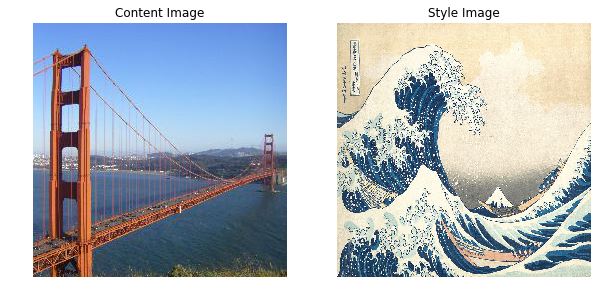

In [58]:
plt.figure(figsize=(10,10))
plt.axis('off')

content = load_img(contents['golden gate']).astype('uint8')
style = load_img(styles['kanazawa'])

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

## Image Preprocessing

Tambahkan fungsi untuk memproses data dengan melakukan normalisasi agar sesuai dengan model

In [0]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

tambahkan juga fungsi untuk mengembalikan hasil model menjadi image agar bisa ditampilkan

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = x.reshape(img_shape)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [batch, height, width, channel] or [height_width_channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessiing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# VGG19

Dalam hal ini, kita muat model pretraining VGG19 untuk mengekstrak feature map gambar content, style dan hasil citra yang dibangkitkan

Kita gunakan VGG karena model ini relatif simpel dibandingkan model lain seperti ResNet, Inception, dan lainnya

Fitur hasil VGG19 dalam praktiknya lebih baik untuk Style Transfer dibandingkan model lain

## Output Layer

Untuk mendapatkan representasi content dan style, kita ambil beberapa layer di dalam model.


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)



## Load VGG19 Model

In [0]:
def get_model():
  
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return models.Model(vgg.input, model_outputs)

# Define Loss

## Content Loss
Secara sederhana, content loss adalah element-wise error dari feature map target content dengan feature map hasil generate gambar

In [0]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

## Style Loss
Untuk Style Loss sedikit lebih panjang. Untung menghitung Style, mula-mula kita harus menghitung Gram Matrix

Kemudian sama seperti sebelumnya, kita kalkulasi Style Loss sebagai MSE dari Gram Matrix target style dan Gram Matrix hasil generate gambar

In [0]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    # height, width, num filters of each layer
    # We scale the loss at a given layer by the size of the feature map and the number of filters
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))# / (4. * (channels ** 2) * (width * height) ** 2)

# Gradient Descent

## Extract Feature of an Image
Helper function untuk membuka gambar konten dan style, memproses propagasi, dan menerima output feature map

In [0]:
def get_feature_representations(model, content_path, style_path):
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)

    # batch compute content and style features
    stack_images = np.concatenate([style_image, content_image], axis=0)
    model_outputs = model(stack_images)

    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
    content_features = [content_layer[1] for content_layer in model_outputs[num_style_layers:]]
    
    return style_features, content_features

## Computing the loss and gradients


In [0]:

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    """This function will compute the loss total loss.

    Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.

    Returns:
    returns the total loss, style loss, content loss, and total variational loss
    """
    style_weight, content_weight = loss_weights

    # Feed our init image through our model. This will give us the content and 
    # style representations at our desired layers. Since we're using eager
    # our model is callable just like any other function!
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

Then computing the gradients is easy:

In [0]:
@tf.function
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

# Style Transfer Function

Fungsi lengkap untuk menjalankan proses Neural Style Transfer

In [0]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
    display_num = 100
    # We don't need to (or want to) train any layers of our model, so we set their
    # trainable to false. 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False

    # Get the style and content feature representations (from our specified intermediate layers) 
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    # Set initial image
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
    # Create our optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=5)


    # For displaying intermediate images 
    iter_count = 1

    # Store our best result
    best_loss, best_img = float('inf'), None

    # Create a nice config 
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    # For displaying
    num_rows = (num_iterations / display_num) // 5
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        # grads, _ = tf.clip_by_global_norm(grads, 5.0)
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 
    
        if loss < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = init_image.numpy()

        if i % display_num == 0:
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                'style loss: {:.4e}, '
                'content loss: {:.4e}, '
                'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
            start_time = time.time()
      
        # Display intermediate images
        if iter_count % display_num==0:
          plt.figure(figsize=(5,5))
          plot_img = init_image.numpy()
          plot_img = deprocess_img(plot_img)
          plt.imshow(plot_img)
          plt.title('Iteration {}'.format(i + 1))
          plt.axis('off')
          plt.show()
        
        iter_count += 1
    print('Total time: {:.4f}s'.format(time.time() - global_start))

    return best_img, best_loss 

---
# Test Neural Style Transfer

sekarang semua fungsi sudah siap, mari kita coba

In [48]:
content_in = contents['turtle']
style_in = styles['kanazawa']

best, best_loss = run_style_transfer(content_in, style_in, num_iterations=1500)

  73728/Unknown - 0s 0us/step

OSError: ignored

## Visualize outputs
visualisasikan hasil citra yang dibangkitkan

In [0]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(15, 15))
    x = deprocess_img(best_img)
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 3, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 3, 2)
    imshow(style, 'Style Image')

    plt.subplot(1, 3, 3)
    plt.imshow(x)
    plt.title('Output Image')
    plt.show()

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(x)
        plt.title('Output Image')
        plt.show()

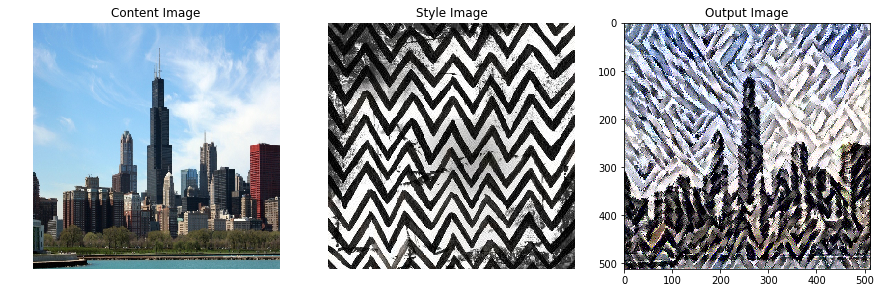

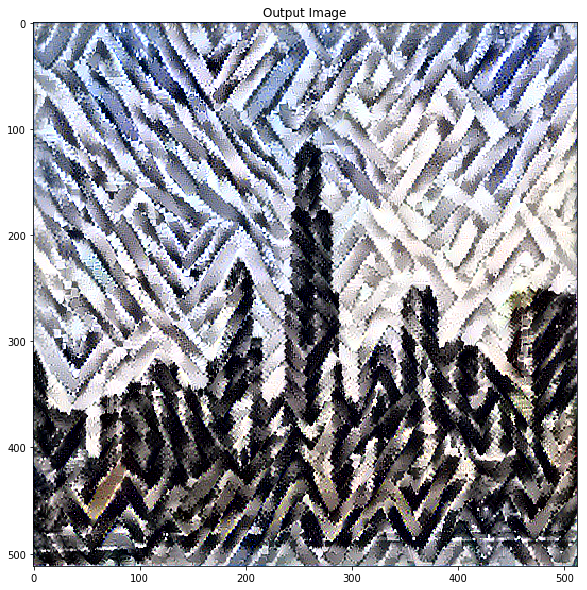

In [25]:
show_results(best, content_in, style_in)

<p>Copyright &copy; 2019 <a href=https://www.linkedin.com/in/andityaarifianto/>ADF</a> </p>